<b>Исследование синхронизации нейроморфных сетей тесного мира.</b>

Участники:\
    Пеганов Никита\
    Диана Мустаева\
    Роман Головин

In [4]:
%matplotlib inline

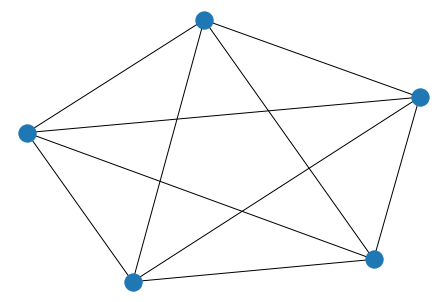

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

K5 = nx.complete_graph(5)
nx.draw(K5)
plt.show()